In [1]:

import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # "0,1,2,3" # "0"

In [2]:
import torch
import numpy as np
import h5py
import cv2
import PIL
import os, sys, gc
import argparse
from glob import glob
from core.get_args import get_args
from core.produce_denoised_img import produce_denoised_img_no_crop
from core.utils import TedataLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from core.watershed import watershed,watershed_per_img,watershed_original
from core.median_filter import apply_median_filter_cpu, apply_median_filter_gpu, apply_median_filter_gpu_simple
%load_ext autoreload
%autoreload 2



In [3]:
def save_eps(img,path):
    if type(img) == torch.Tensor:
        img = img.cpu().numpy()
    img = (img-img.min())/(img.max()-img.min())
    img = PIL.Image.fromarray((img*255).astype('uint8'))
    img.save(path,dpi=(300,300),mode='EPS')

In [4]:
folder_name = "./N2N_output_230917_wholeimg"
os.makedirs(folder_name, exist_ok=True)


In [5]:
def load_img_dict(target_x,target_y,debug=True):
    possible_f_num = ['F01','F02','F04','F08','F16','F32']
    x_f_num = []
    if target_x == 'F#':
        for f_num in possible_f_num:
            if f_num != target_y:
                x_f_num.append(f_num)
            else :
                break
    else :
        x_f_num = [target_x]
    x_f_num.append('F32')
    x_f_num.append('F64')
    print(x_f_num)
    img_dict = {}
    path_list = ["/home/hyunwoong/FBI-Denoiser/data/Samsung_tmp_dataset/Samsung_SNU",
                 "/home/hyunwoong/FBI-Denoiser/data/Samsung_tmp_dataset/Samsung+SNU+dataset+221115"
                 ]
    # data_path = "/mnt/ssd/hyun/fbi-net/FBI-Denoiser/data/Samsung_SNU_1474x3010_aligned_ordered/" 
    debug = True
    for data_path in path_list:
        print("=====",data_path, "=====")
        for set_num in sorted(os.listdir(data_path)):
            if set_num[0] == '.' :
                continue
            set_path = os.path.join(data_path,set_num)
            set_number = int(set_num.split(" ")[-1][:-1])
            set_num = f"{set_num[1:4]}{set_number:02d}"
            print("=====",set_num, "=====")
            img_dict[set_num] = {}
            # if debug is True:
            #     print(set_num)
            f_num_list = os.listdir(set_path)
            # print(f_num_list)
            for f_num in f_num_list:
                f_path = os.path.join(set_path,f_num)
                f_number = int(f_num[1:])
                f_num = f"F{f_number:02d}"
                # print(set_num,f_num)
                if f_num not in x_f_num:
                    print(f_num , " is not in ", x_f_num)
                    continue
                # img_dict[set_num][f_num] = None
                img_dict[set_num][f_num] = {}
                img_list = sorted(os.listdir(f_path))
                img_list = list(filter(lambda x : ".ipynb_checkpoints" not in x,img_list))
                
                for filename in sorted(img_list):
                    
                    img_path = os.path.join(f_path,filename)
                    image_idx = int(filename.split("_")[0])
                    filename = f"{set_num}_{f_num}_{image_idx:02d}.png"
                    if debug is True:
                        print(f_num," & ",filename)
                    img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE) 
                    # img_dict[set_num][f_num].append(img)
                    # img = np.expand_dims(img,axis=0)
                    img = np.expand_dims(img,axis=0) / 255.
                    img_dict[set_num][f_num][filename] = img
                    # if img_dict[set_num][f_num] is None:  
                    #     img_dict[set_num][f_num] = img
                    # else :
                    #     img_dict[set_num][f_num] = np.append(img_dict[set_num][f_num],img,axis=0)
                    if debug is True:
                        print(set_num,f_num,img.shape)
    if debug is True:
        print(img_dict.keys())
        for set_num in img_dict.keys():
            print(" ",img_dict[set_num].keys())
            for f_num in img_dict[set_num].keys():
                print("   ",img_dict[set_num][f_num].keys())
    print("====== load img_dict complete ======")
    return img_dict
                        

In [ ]:
img_dict = load_img_dict('F01','F02',debug=True)

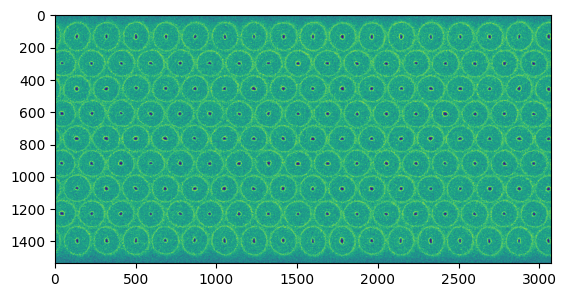

In [7]:
plt.imshow(img_dict['SET06']['F01']['SET06_F01_01.png'][0][256:-256,])

In [8]:

import itertools
def get_fbi_weight(f_num_list = ['F#','F01','F02','F04','F08','F16','F32','F64'],loss = 'MSE_Affine',filter_keyword = ['median']):
    comb = list(itertools.combinations(f_num_list,2))
    total_fbi_weight_list = {}
    for x_f_num,y_f_num in comb:
        fbi_weight_list = glob(f"../weights/230*_FBI_Net*x_as_{x_f_num}*y_as_{y_f_num}*{loss}*")
        for keyword in filter_keyword:
            fbi_weight_list = list(filter(lambda x : keyword not in x,fbi_weight_list))
        total_fbi_weight_list += sorted(list(fbi_weight_list))
        print(x_f_num,y_f_num)
        for fbi_weight in fbi_weight_list:
            print(fbi_weight)
    return total_fbi_weight_list

In [2]:
!ls ../weights/2309*F02*F08*

../weights/230901_FBI_Net_Grayscale_N2N_F02-F08_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w


In [10]:
gc.collect()
debug= True
partial_check = True
target_fbi_weight = [
    # "../weights/230914_FBI_Net_EMSE_Affine_Grayscale_N2N_F01-F01_Samsung_EMSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    
    "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F01_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F02_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F04_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F08_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230920_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F32_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256_epoch15.w",
    # "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F01-F32_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230920_FBI_Net_MSE_Grayscale_N2N_F01-F32_Samsung_MSE_layers_x17_filters_x64_cropsize_256.w",
    # "../weights/230914_FBI_Net_N2V_Grayscale_N2N_F01-F01_Samsung_N2V_layers_x17_filters_x64_cropsize_256.w",
    
    "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F02-F02_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F02-F04_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",
    "../weights/230914_FBI_Net_MSE_Affine_Grayscale_N2N_F04-F04_Samsung_MSE_Affine_layers_x17_filters_x64_cropsize_256.w",

    # "../weights/230914_NAFNet_light_MSE_Affine_Grayscale_N2N_F01-F01_Samsung_MSE_Affine.w",
    # "../weights/230914_NAFNet_light_MSE_Affine_Grayscale_N2N_F01-F02_Samsung_MSE_Affine.w",
    # "../weights/230914_NAFNet_light_MSE_Affine_Grayscale_N2N_F01-F04_Samsung_MSE_Affine.w",
    # "../weights/230914_NAFNet_light_MSE_Affine_Grayscale_N2N_F01-F08_Samsung_MSE_Affine.w",
    
]


In [11]:


def parsing_weight_name(fbi_weight_dir):
    target_f = fbi_weight_dir.split("N2N_")[1].split("_Samsung")[0]
    target_x,target_y = target_f.split("-")
    info = "_".join(fbi_weight_dir.split("_")[1:]).split("_Grayscale")[0]
    arch, loss_func = "_".join(info.split("_")[:2]), "_".join(info.split("_")[2:])
    try: 
        add_info = fbi_weight_dir.split("cropsize_256_")[1].split(".w")[0]
    except :
        add_info = ""
    return target_x,target_y, arch, loss_func, add_info


In [12]:

args = get_args(env='colab')
args.pge_weight_dir = None #pge_weight_dir
args.loss_function = "MSE_Affine"
args.noise_type = 'Poisson-Gaussian'
args.model_type = 'NAFNet_light'#'FBI_Net'
# args.set_num = '1'
args.data_name = 'Samsung'
args.data_type = 'Grayscale'
args.lr = 0.001
args.num_layers = 17
args.num_filters = 64
# args.crop_size = 200
args.debug = False

In [15]:
from re import T
from core.utils import get_PSNR,get_SSIM


    
debug = False
imshow = True
metric = {}
for weight_idx,fbi_weight_dir in enumerate(target_fbi_weight):

    target_x,target_y, arch, loss_func,add_info = parsing_weight_name(fbi_weight_dir)
    if debug is True:
        print(fbi_weight_dir)
        # print(median_filter_input,"median_filter_input")
    # key = f"{target_x}-{target_y}_{dataset_version}"
    key = f"{target_x}-{target_y}_{arch}"
    if loss_func != 'MSE_Affine':
        key += f"_{loss_func}"
    if add_info != "":
        key += f"_{add_info}"
    model_img_path = f"{folder_name}/{key}"
    os.makedirs(model_img_path,exist_ok=True)
    args.loss_function = loss_func
    args.model_type = arch
    if args.loss_function == 'EMSE_Affine':
        args.pge_weight_dir = "../weights/230914_PGE_Net_Noise_est_Grayscale_N2N_F01-F01_Samsung_Noise_est_cropsize_256_vst_MSE.w"
    else :
        args.pge_weight_dir = None
    print(f"========= {key}  & {loss_func }=========")
    
    model = produce_denoised_img_no_crop(_pge_weight_dir=None,_fbi_weight_dir = fbi_weight_dir,_args = args)
    
    # DENOISE IMAGE
    if target_x == 'F#':
        f_num = 'F01'
    else :
        f_num = target_x
        
    if f_num in ['F08','F16','F32','F64']:
        set_num_list = ['SET01','SET02','SET03','SET04','SET05','SET06','SET07','SET08','SET09','SET10']
    else :
        set_num_list = ['SET05','SET06','SET07','SET08','SET09','SET10'] # ['SET06']#
    if weight_idx == 0:
        metric['median_filter'] = {
            'PSNR' : [],
            'SSIM' : []
        }
        metric['raw'] = {
                'PSNR' : {},
                'SSIM' : {}
            }
        # metric['bm3d'] = {
        #     'PSNR' : [],
        #     'SSIM' : []
        # }
    metric[key] = {'before_PSNR' : {},
            'before_SSIM' : {},
            'PSNR' : {},
            'SSIM' : {}
        }
    print(set_num_list)
    img_dict = load_img_dict(f_num,target_y,debug=False)
    for set_num in img_dict.keys():
        for f_num in [target_x]:
            if f_num in ['F01','F02','F04'] and set_num in ['SET01','SET02','SET03','SET04']:
                continue
            
                # print(f"Since F#, f_num : {f_num} Start")
            print(f"Denoising SET : {set_num}, f_num : {f_num} Start")
            for idx,(filename, img) in enumerate(img_dict[set_num][f_num].items()):
                img = np.expand_dims(img, axis=0) # 1,1536x3074
                F32_img = img_dict[set_num]['F32'][filename.replace(f_num,'F32')][0]
                clean_img = img_dict[set_num]['F64'][filename.replace(f_num,'F64')][0]
                print(filename,set_num,f_num,idx,img.shape)
                denoised_img = model.eval(img)[0][0]
                img = img[0][0]
                metric[key]['PSNR'][filename.split(".")[0]] = get_PSNR(clean_img[256:-256],denoised_img[256:-256])
                metric[key]['SSIM'][filename.split(".")[0]] = get_SSIM(clean_img[256:-256],denoised_img[256:-256])
                
                if os.path.exists(f"{model_img_path}/{filename}") is False:
                    print("imwrite : ",f"{model_img_path}/{filename}")
                    if type(denoised_img) == torch.Tensor:
                        denoised_img = denoised_img.cpu().detach().numpy()
                    cv2.imwrite(f"{model_img_path}/{filename}",denoised_img[0]*255)
                
                if weight_idx == 0:
                    metric['raw']['PSNR'][filename.split(".")[0]] = get_PSNR(clean_img[256:-256],img[256:-256])
                    metric['raw']['SSIM'][filename.split(".")[0]] = get_SSIM(clean_img[256:-256],img[256:-256])
                
                    medianfilterd_img = apply_median_filter_gpu_simple(img)[0][0]
                    median_psnr, median_ssim =  get_PSNR(clean_img[256:-256],medianfilterd_img[256:-256]), get_SSIM(clean_img[256:-256],medianfilterd_img[256:-256])
                    metric['median_filter']['PSNR'].append(median_psnr)
                    metric['median_filter']['SSIM'].append(median_ssim)
                    
                    if set_num == 'SET06' and idx == 0:
                        filename = f"{folder_name}/F32.eps"
                        if os.path.exists(filename) is False:
                            save_eps(F32_img,filename)
                        filename = f"{folder_name}/median_filter_f32.eps"
                        if os.path.exists(filename) is False:
                            save_eps(medianfilterd_img,filename)
                    
            print(f"Denoising SET : {set_num}, f_num : {f_num} End")
    del model
    gc.collect()


========= F01-F01_FBI_Net  & MSE_Affine=========
['SET05', 'SET06', 'SET07', 'SET08', 'SET09', 'SET10']
['F01', 'F32', 'F64']
===== /home/hyunwoong/FBI-Denoiser/data/Samsung_tmp_dataset/Samsung_SNU =====
===== SET01 =====
['F32', 'F8', 'F64', 'F16']
F32  &  SET01_F32_10.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_11.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_12.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_13.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_14.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_15.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_16.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_01.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_02.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_03.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_04.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_05.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_06.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_07.png
SET01 F32 (1, 2048, 3072)
F32  &  SET01_F32_08.png
SET01 F32 (

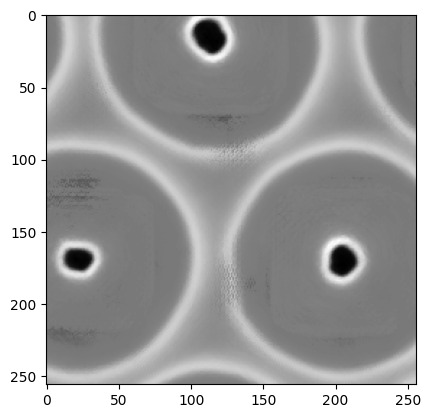

In [ ]:
plt.imshow(denoised_img[1000:1256,1000:1256],cmap='gray')

In [ ]:
metric['F01-F01_FBI_Net']['before_PSNR'].values()

dict_values([])

In [ ]:
metric['raw']

{'PSNR': {'SET10_F01_01': 11.383042231359127,
  'SET10_F01_02': 11.311417041687445,
  'SET05_F01_01': 11.304239877909414,
  'SET05_F01_02': 11.219562990080336,
  'SET06_F01_01': 11.620390516619544,
  'SET06_F01_02': 11.464705500185218,
  'SET07_F01_01': 11.825318292394403,
  'SET07_F01_02': 11.696640828962636,
  'SET08_F01_01': 11.555225406099161,
  'SET08_F01_02': 11.556536161933282,
  'SET09_F01_01': 11.73978923836456,
  'SET09_F01_02': 11.66917048513116},
 'SSIM': {'SET10_F01_01': 0.02053285966398838,
  'SET10_F01_02': 0.020659344342844083,
  'SET05_F01_01': 0.021363651552812737,
  'SET05_F01_02': 0.02104732648998464,
  'SET06_F01_01': 0.022122376477199186,
  'SET06_F01_02': 0.02178420282934655,
  'SET07_F01_01': 0.019448018597106494,
  'SET07_F01_02': 0.022182790924475632,
  'SET08_F01_01': 0.023102675456254423,
  'SET08_F01_02': 0.02275520114344225,
  'SET09_F01_01': 0.021866608567648466,
  'SET09_F01_02': 0.021687121920167213}}

In [16]:
refined_metric = {}
for key in metric.keys():
    print(key)
    refined_metric[key] = {}
    for sub_key in metric[key].keys():     
        print(key,sub_key)
        if type(metric[key][sub_key]) == dict:
            metric[key][sub_key] = list(metric[key][sub_key].values())
        refined_metric[key][f'{sub_key}'] = np.mean(metric[key][sub_key])
        

import pandas as pd
refined_metric = pd.DataFrame(refined_metric)
refined_metric

median_filter
median_filter PSNR
median_filter SSIM
raw
raw PSNR
raw SSIM
F01-F01_FBI_Net
F01-F01_FBI_Net before_PSNR
F01-F01_FBI_Net before_SSIM
F01-F01_FBI_Net PSNR
F01-F01_FBI_Net SSIM
F01-F02_FBI_Net
F01-F02_FBI_Net before_PSNR
F01-F02_FBI_Net before_SSIM
F01-F02_FBI_Net PSNR
F01-F02_FBI_Net SSIM
F01-F04_FBI_Net
F01-F04_FBI_Net before_PSNR
F01-F04_FBI_Net before_SSIM
F01-F04_FBI_Net PSNR
F01-F04_FBI_Net SSIM
F02-F02_FBI_Net
F02-F02_FBI_Net before_PSNR
F02-F02_FBI_Net before_SSIM
F02-F02_FBI_Net PSNR
F02-F02_FBI_Net SSIM
F02-F04_FBI_Net
F02-F04_FBI_Net before_PSNR
F02-F04_FBI_Net before_SSIM
F02-F04_FBI_Net PSNR
F02-F04_FBI_Net SSIM
F04-F04_FBI_Net
F04-F04_FBI_Net before_PSNR
F04-F04_FBI_Net before_SSIM
F04-F04_FBI_Net PSNR
F04-F04_FBI_Net SSIM


/mnt/ssd/hyun/fbi-net/env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/ssd/hyun/fbi-net/env/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,median_filter,raw,F01-F01_FBI_Net,F01-F02_FBI_Net,F01-F04_FBI_Net,F02-F02_FBI_Net,F02-F04_FBI_Net,F04-F04_FBI_Net
PSNR,17.663364,11.528837,17.483187,17.639350,17.591006,17.066696,17.201471,17.136316
SSIM,0.357454,0.021546,0.352791,0.352513,0.351554,0.349900,0.350445,0.349227
before_PSNR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
before_SSIM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
refined_metric.drop(['before_PSNR','before_SSIM'],inplace=True)
refined_metric

,median_filter,raw,F01-F32_FBI_Net
PSNR,17.663364,11.528837,15.019464
SSIM,0.357454,0.021546,0.315122


In [ ]:
refined_metric.drop(['before_PSNR','before_SSIM'],inplace=True)
refined_metric

,median_filter,raw,F01-F01_FBI_Net_EMSE_Affine,F01-F01_FBI_Net,F01-F02_FBI_Net,F01-F04_FBI_Net,F01-F08_FBI_Net,F01-F32_FBI_Net_epoch15,F01-F32_FBI_Net,F01-F32_FBI_Net_MSE,F01-F01_FBI_Net_N2V,F01-F01_NAFNet_light,F01-F02_NAFNet_light,F01-F04_NAFNet_light,F01-F08_NAFNet_light
PSNR,17.663364,11.528837,15.116227,17.483187,17.639350,17.591006,17.322812,15.249090,15.019464,15.283499,15.139877,17.467088,17.430520,17.671412,17.342680
SSIM,0.357454,0.021546,0.083735,0.352791,0.352513,0.351554,0.352502,0.317023,0.315122,0.317341,0.081722,0.352333,0.352156,0.352124,0.352738


In [ ]:
refined_metric.to_csv(f"{folder_name}/metric_whole_N2N_vs_RN2N.csv")

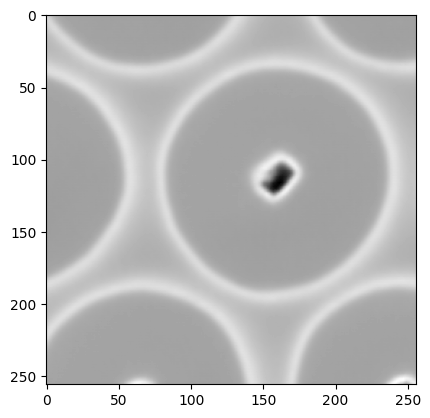

In [ ]:
plt.imshow(denoised_img[256:-256][800:1056,500:756],cmap='gray')

In [ ]:
from knockknock import telegram_sender
@telegram_sender(token='1531143270:AAFTord-4Bi370ohc39wGyYhjGi7_VjZTwU', chat_id=1597147353)
def denoising_end():
    print("Denoising End")
denoising_end()
!date

Denoising End
Fri Sep 22 07:55:42 UTC 2023
